# Network inference from Brian network

In [1]:
from brian2 import *
import pandas as pd
%matplotlib inline

#### Parameters ####
params = {}
params['N'] = 1000 # number of neurons in total;
params['t'] = 300 #sec, simulation time
params['V_r'] = -70 #MV, reset voltage
params['V_s'] = -50 #mV, spike threshold
params['EL'] = -49 #mV, resting membrane voltage
params['T_ref'] = 5.0 #ms
params['we_init'] = 2*(60*0.27/10) #mV #1 #nS #
params['wi_init'] = (-20*4.5/10) #mV #10 #nS
params['pe'] = 0.1 #excitatory connection probability
params['pi'] = 0.2 #inhibitory connection probability
params['taue'] = 2 #ms, excitatory time constant
params['taui'] = 5 #ms, inhibitory time constant
params['d'] = 1.0 #ms, synaptic delay


# exponential IF
params['Delta_T'] = 0.0 #mV
params['V_T'] = params['V_s']+5*params['Delta_T'] #mV, effective spike threshold
params['rate'] = 5.0 #Hz (rate of external stimuli)
params['ext_weight'] = 2.0 #mV or nS, external weights
params['C'] = 200 # pF, capacitance
params['gL'] = 10 # nS, leak conductance
params['tau_m'] = params['C']/params['gL']

# leaky IF
params['tau_m'] = 20.0 #ms, membrane time constant

# adaptation
params['tauw'] = 100 #ms
params['a'] = 1 # nS
params['b'] = 0.04 #nA
params['Delta_w'] = 0.5 #mV/ms

# conductance synapses
params['Ee'] = 0 #mV
params['Ei'] = -80 #mV



In [2]:
from generate_network import *
case = 'leaky'
adapt = False
syn = 'current'
synname = "data_N1000_T3000_leaky_current_synapses_2.pkl"
if_network(params,case,adapt,syn,synname)
filename = 'data_N'+str(params['N'])+'_T'+str(params['t'])+'_'+case+'_'+syn
if adapt==True:
    filename = filename + '_adapt'

('Number of excitatory neurons:', 800)
('Number of inhibitory neurons:', 200)


WARNING    /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sympy/matrices/matrices.py:2479: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()
 [py.warnings]


File saved: data_N1000_T300_leaky_current
[ True]


In [61]:
filename = 'data_N1000_T3000_leaky_current'
Nneurons_obs = 30  # number of neurons whose spike trains are observed
rate_min = 5

### Load already existing data

[174 794 558 345  17 769 249 617  40 741 759 773 627 263 445 879 957 944
 869 958 876 947 941 916 882 959 825 820 943 898]


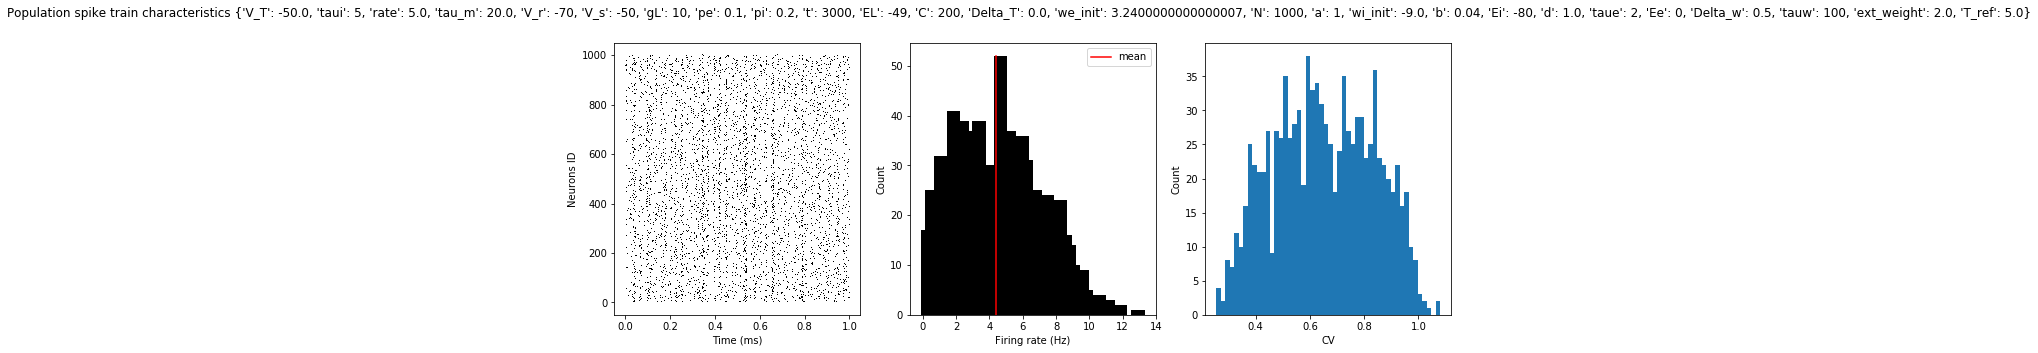

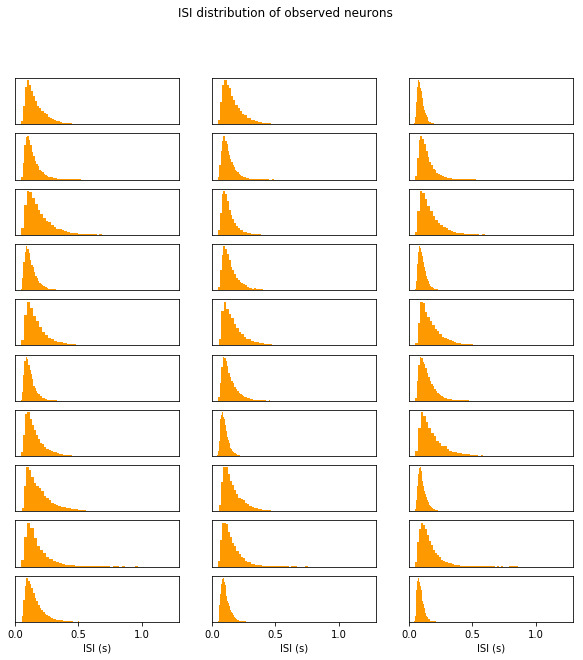

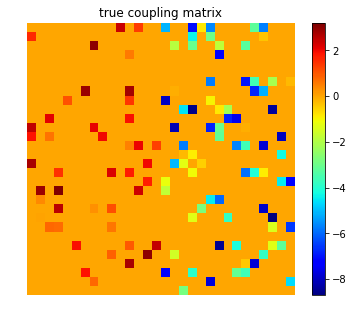

In [62]:
# load data --------------
if filename is not None:
    df = pd.read_pickle(filename+".pkl")
    
sptimes = df['spiketimes'][0]
spid = df['spikeid'][0]
Nneurons_tot = df['params'][0]['N']
Jmat = df['Jmat'][0]
sim_t = df['params'][0]['t']

# VISUALIZE SPIKE PROPERTIES OF OBSERVED NEURONS --------------
ISI = {}
ISIstat = {
    'count':np.zeros(Nneurons_tot),
    'mean': np.zeros(Nneurons_tot),
    'std':np.zeros(Nneurons_tot),
    'cv':np.zeros(Nneurons_tot)
}
for i_N in range(Nneurons_tot):
    ISI[i_N] = np.diff(sptimes[spid==i_N])
    ISIstat['count'][i_N] = len(ISI[i_N])
    if ISIstat['count'][i_N]!=0:
        ISIstat['mean'][i_N] = np.mean(ISI[i_N])
        ISIstat['std'][i_N] = np.std(ISI[i_N])
        ISIstat['cv'][i_N] = np.std(ISI[i_N])/np.mean(ISI[i_N])
    else:
        ISIstat['cv'][i_N] = 0
        
figure(figsize=(15,5))
suptitle('Population spike train characteristics ' + str(df['params'][0]))
# raster
subplot(131)
idx = np.array(sptimes) < 1
plot(sptimes[idx],spid[idx],'k,',lw=0)
ylabel('Neurons ID')
xlabel('Time (ms)')

# firing rate
subplot(132)
fr = 1/(ISIstat['mean'])
fr[np.isinf(fr)] = 0
count,edges = np.histogram(fr,bins=50)
bar(edges[1:]-edges[:-1]+edges[:-1],count,facecolor='k')
plot([np.mean(fr),np.mean(fr)],[0,np.max(count)],'r',label='mean')
xlabel('Firing rate (Hz)')
ylabel('Count')
legend()

# coefficient of variation
subplot(133)
hist(ISIstat['cv'],50)
xlabel('CV')
ylabel('Count')
savefig('plots/%s_population.pdf' %filename,bbox_inches='tight')

figure(figsize=(10,10))
suptitle('ISI distribution of observed neurons')

# change observed neurons id to neurons with at least mean fr=5 Hz
np.random.seed(100)
num_ex = int(Nneurons_obs/2)
num_inh = Nneurons_obs - num_ex

#obs_neurons_ex = np.random.permutation(np.where((fr>=rate_min) & (mean(Jmat,1)>0))[0])[:num_ex]
#obs_neurons_inh = np.random.permutation( np.where((fr>=rate_min) & (mean(Jmat,1)<0))[0])[:num_inh]
#obs_neurons_ind = np.concatenate([obs_neurons_ex,obs_neurons_inh])

# load observed neurons
obs_neurons_ind = np.load("data_N1000_T3000_leaky_current_obsneurons.npy")
print(obs_neurons_ind)
Jmat_obs = Jmat[obs_neurons_ind,:][:,obs_neurons_ind] #connectivity matrix of observed neurons

nb_cols = 3
nb_rows = int(ceil(Nneurons_obs/float(nb_cols)))
x_max = np.max([np.max(ISI[i]) for i in obs_neurons_ind])

for count,ind in enumerate(obs_neurons_ind):
    subplot(nb_rows,nb_cols,count+1)
    hist(ISI[ind],50,facecolor=[1,0.6,0])
    yticks([], [])
    xlim((0,x_max))
    if count<(nb_rows-1)*nb_cols:
        xticks(())
    else:
        xlabel('ISI (s)')
    
    
savefig('plots/%s_ISI_dist.pdf' %filename)
show()

# into dictionary
Spt_dict = {}
for i_N,id_N in enumerate(obs_neurons_ind):
    idx = np.where(spid == id_N)[0]
    Spt_dict[i_N] = sptimes[idx]*1000 #convert to ms

# save observed connectivity matrix
np.save('%s_Jobs' %filename, Jmat_obs.T)

# visualize connectivity matrix    
figure(figsize=(6,5))
subplot(111)
imshow(Jmat_obs.T, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet)
title('true coupling matrix')
colorbar()
axis('off')
savefig('plots/%s_Jobs.pdf' %filename)
show() 

# save indices of observed neurons
np.save('%s_obsneurons.npy' %filename,obs_neurons_ind)

### Cross correlogram

In [63]:
import random

def crosscorr(x1,x2,steps):
    ac = np.array([np.correlate(x1[:-t],x2[t:])[0] for t in steps[steps>0]])
    ac = np.insert(ac,0,np.correlate(x1,x2)[0])
    ac2 = np.array([np.correlate(x1[t:],x2[:-t])[0] for t in abs(steps[steps<0])])
    ac = np.concatenate([ac2,ac])
    return ac

# binary spike matrix for correlation
spikes = np.zeros((Nneurons_obs,int(sim_t)*1000))
for i_N in range(Nneurons_obs):
    spikes[i_N,Spt_dict[i_N].astype(int)] = 1.0
        
        
obs_time = 300 #sec of raster to use
stepsize = 2 #ms
maxlag = 20.0 #ms
steps = np.arange(-int(maxlag),int(maxlag)+1,stepsize) #omit 0 lag

CCG = np.zeros((Nneurons_obs,Nneurons_obs,2*int(maxlag/stepsize)+1))
CCG_correct = np.zeros((Nneurons_obs,Nneurons_obs,2*int(maxlag/stepsize)+1))
for i_N in range(Nneurons_obs):
    for j_N in range(Nneurons_obs):
        x1 = spikes[i_N,:obs_time*1000]
        x2 = spikes[j_N,:obs_time*1000]

        cg = crosscorr(x1,x2,steps)

        if i_N==j_N:
            cg[len(cg)/2] = 0
            
        CCG[i_N,j_N,:] = cg


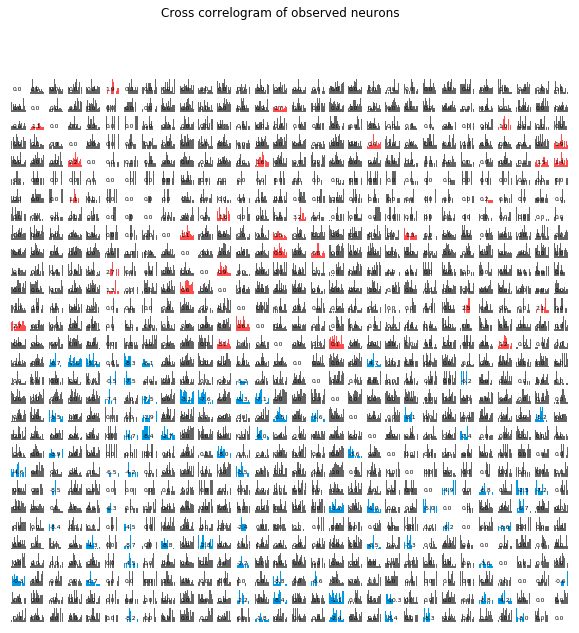

Red: neuron of row ID excites neuron of column ID


In [60]:
f = figure(figsize=(10,10))
suptitle('Cross correlogram of observed neurons')

sp = 1
for i_N in range(Nneurons_obs):
    for j_N in range(Nneurons_obs):        
        # plot
        col = [0.4,0.4,0.4]
        if i_N==j_N:
            col = [1,0.6,0]
        elif Jmat_obs[i_N,j_N]>0:
            col = [1,0.3,0.3]
        elif Jmat_obs[i_N,j_N]<0:
            col = [0,0.6,0.9]
        
        ax = f.add_subplot(Nneurons_obs,Nneurons_obs,sp)
        bar(steps,CCG[i_N,j_N,:],width=stepsize,facecolor=col)
        ax.text(0.1,0.2,str(np.round(Jmat_obs[i_N,j_N],1)),transform=ax.transAxes,size=6)
        if i_N<(Nneurons_obs-1)*Nneurons_obs:
            ax.set_xticks([])
        
        ax.set_yticks([])
        box()
        sp += 1
        
savefig('plots/%s_CCG.pdf' %filename)
show()

print 'Red: neuron of row ID excites neuron of column ID'


### Evaluate cross-correlogram

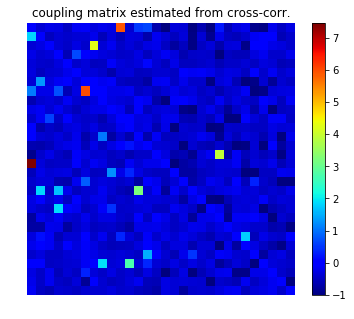

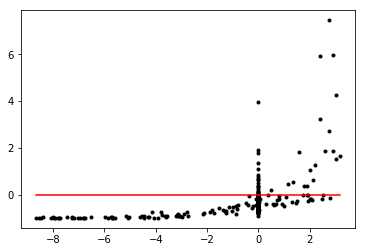

Correlation coefficient: 0.43680646513314975


In [71]:
alpha = np.zeros((Nneurons_obs,Nneurons_obs))
for i_N in range(Nneurons_obs):
    for j_N in range(Nneurons_obs):
        if i_N!=j_N:
            x1 = spikes[i_N,:obs_time*1000]
            x2 = spikes[j_N,:obs_time*1000]
            fr1 = np.sum(x1)/obs_time #firing rate neuron 1
            fr2 = np.sum(x2)/obs_time #firing rate neuron 2
            
            e = fr1*fr2*obs_time*stepsize/1000 #noise
            cg = CCG[i_N,j_N][int(len(steps)/2)+1:] #cross correlogram for positive lags
            d = cg - e #difference to noise
            # check first time bin
            if d[0]>0: #excitatory
            
                dpos = (cg>e).astype(float)
                delay = 0
                sigma = np.where(np.diff(dpos)==-1)[0][0]+1 - delay
                #d_ex = np.max(d[delay:delay+sigma])
                d_ex = d[delay]
                alpha_ex = d_ex*sigma*fr2/e
                alpha[i_N,j_N] = alpha_ex
            else:
                dneg = (cg<e).astype(float)
                delay = np.where(dneg)[0][0]
                #sigma = np.where(np.diff(dneg)==-1)[0]
                #if len(sigma)!=0:
                #    sigma = sigma[0]+1 - delay
                #    d_inh = np.min(d[delay:delay+sigma])
                #else:
                #    d_inh = np.min(d[delay:])
                d_inh = d[delay]
                alpha_inh = d_inh/e
                alpha[i_N,j_N] = alpha_inh
                
# visualize predicted connectivity matrix    
figure(figsize=(6,5))
subplot(111)
imshow(alpha.T, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet)
title('coupling matrix estimated from cross-corr.')
colorbar()
axis('off')
#savefig('plots/%s_Jobs.pdf' %filename)
show() 

figure()
plot(Jmat_obs.flatten(),alpha.flatten(),'ko',ms=3)
plot([np.min(Jmat_obs), np.max(Jmat_obs)],[0,0],'r')
show()

cc = np.corrcoef(np.ravel(alpha),np.ravel(Jmat_obs))[0,1] # correlation
print 'Correlation coefficient:',cc 

### Estimation

In [203]:
num_segments = 1 # number of segments for estimation
total_time = params['t'] - 5
segment_time = floor(total_time/num_segments)
print 'Duration of segments for estimation:',segment_time

Duration of segments for estimation: 295.0


In [204]:
import inference_methods as im
import multiprocessing

d = params['d']  # ms, delay# parameters for estimation (method 1a)
params['pISI_method'] = 'fourier'
f_max = 2000.0 # Hz, determines resolution (accuracy) of ISI density; 
               # 1k seems sufficient in many cases, for finer resolution try 2k or 4k
d_freq = 0.25 # Hz, spacing of frequency grid
d_V = 0.025  # mV, spacing of voltage grid
params['V_lb'] = -150.0  # mV, lower bound
params['V_vals'] = np.arange(params['V_lb'],params['V_s']+d_V/2,d_V)
params['freq_vals'] = np.arange(0.0, f_max+d_freq/2, d_freq)/1000  # kHz
params['V_r_idx'] = np.argmin(np.abs(params['V_vals']-params['V_r'])) 
                    # index of reset voltage on grid, this should be a grid point
                    
# parameters for estimation when using the finite volume method instead of the 
# Fourier method to calculate p_ISI^1, which is optional (and often faster)
use_fvm = True  # False: using Fourier method
if use_fvm:
    params['pISI_method'] = 'fvm' 
    d_V = 0.025  # mV, spacing of voltage grid
    params['V_lb'] = -150.0  # mV, lower bound
    params['V_vals'] = np.arange(params['V_lb'],params['V_s']+d_V/2,d_V)
    params['V_r_idx'] = np.argmin(np.abs(params['V_vals']-params['V_r'])) 
                        # index of reset voltage on grid, this should be a grid point
    params['neuron_model'] = 'LIF'
    params['integration_method'] = 'implicit'
    params['N_centers_fvm'] = 1000  # number of centers for voltage discretization
    params['fvm_v_init'] = 'delta'  # voltage density initialization
    params['fvm_delta_peak'] = params['V_r']  # location of initial density peak
    params['fvm_dt'] = 0.1  # ms, time step for finite volume method
                            # 0.1 seems ok, prev. def.: 0.05 ms 

sigma_init = 3.0  # initial sigma value (initial mu value will be determined by 
                  # sigma_init and empirical mean ISI)
N_tpert = 300  # determines spacing of (potential) perturbation times within ISIs
               # due to coupling; def.: 300            
J_bnds = (-3.0, 3.0)  # mV, min./max. coupling strength 
N_procs = int(5.0*multiprocessing.cpu_count()/6)  # number of parallel processes                

# loop through segments:
for seg in range(num_segments):
    Spt_seg = {}
    for i_N in range(Nneurons_obs):
        Spt_seg[i_N] = Spt_dict[i_N][((Spt_dict[i_N]<(seg+1)*segment_time*1000) & (Spt_dict[i_N]>=seg*segment_time*1000))]
    print(np.max(Spt_seg[0]))
    
    # ESTIMATE PARAMETERS from spike trains -----------------------------------
    start = time.time()
    N = len(Spt_dict.keys())
    args_fixed = (Spt_seg, d, sigma_init, N_tpert, J_bnds, Jmat, params)
    arg_tuple_list = [(iN, N, args_fixed) for iN in range(N)]    
                                                              
    print('starting estimation using {} parallel processes'.format(N_procs))
    # e.g., one process for each neuron
    print('')
    print('likelihood optimization can take several minutes...')
    pool = multiprocessing.Pool(N_procs)
    if use_fvm:
        result = pool.imap_unordered(im.Jij_estim_wrapper_v1, arg_tuple_list)
    else:
        result = pool.imap_unordered(im.Jij_estim_wrapper_v2, arg_tuple_list)
    
    D = {}
    obs_neurons_id = list(Spt_dict.keys())
    D['J_true'] = Jmat_obs.T
    D['mu_estim'] = np.zeros(N)*np.nan
    D['sigma_estim'] = np.zeros(N)*np.nan
    D['logl_uncoupled'] = np.zeros(N)*np.nan
    D['J_estim'] = np.zeros((N,N))
    D['logl_coupled'] = np.zeros((N,N))*np.nan
    
    finished = 0 
    for i_N, mu_estim, sigma_estim, logl_uncoupled, \
        J_estim_row, logl_coupled_row in result:
        finished += 1
        print(('{count} of {tot} estimation parts completed').
              format(count=finished, tot=N)) 
        D['mu_estim'][i_N] = mu_estim
        D['sigma_estim'][i_N] = sigma_estim
        D['logl_uncoupled'][i_N] = logl_uncoupled
        D['J_estim'][i_N,:] = J_estim_row
        D['logl_coupled'][i_N,:] = logl_coupled_row
    
    pool.close()
    Pcc = np.corrcoef(np.ravel(D['J_estim']),np.ravel(D['J_true']))
    print('')
    print('estimation took {dur}s, corr.-coeff. = {cc}'.format(
           dur=np.round(time.time() - start,2), cc=Pcc[0,1]) )
    print('')
    np.save('%s_Jestim_%s' %(filename, seg), D['J_estim'])
         

294984.7
starting estimation using 3 parallel processes

likelihood optimization can take several minutes...
mean ISI of neuron 1 = 178.19
mean ISI of neuron 2 = 169.71
mean ISI of neuron 3 = 150.63
neuron 2: mu_estim = -2.57, sigma_estim = 0.3
neuron 3: mu_estim = -2.56, sigma_estim = 0.3
neuron 1: mu_estim = -2.57, sigma_estim = 0.3
precalculations for neuron 2 took 220.53s
precalculations for neuron 3 took 238.79s
mean ISI of neuron 4 = 132.55
1 of 30 estimation parts completed
precalculations for neuron 1 took 273.62s
mean ISI of neuron 5 = 176.39
2 of 30 estimation parts completed
neuron 4: mu_estim = -2.56, sigma_estim = 0.3
mean ISI of neuron 6 = 188.57
3 of 30 estimation parts completed
neuron 5: mu_estim = -2.57, sigma_estim = 0.3
neuron 6: mu_estim = -2.58, sigma_estim = 0.3
precalculations for neuron 4 took 180.75s
mean ISI of neuron 7 = 116.5
4 of 30 estimation parts completed
neuron 7: mu_estim = -2.55, sigma_estim = 0.3
precalculations for neuron 5 took 296.29s
precalcula

('Correlation coefficient for excitatory neurons:', 0.6279871375025656)
('Correlation coefficient for inhibitory neurons:', 0.4574794159198303)


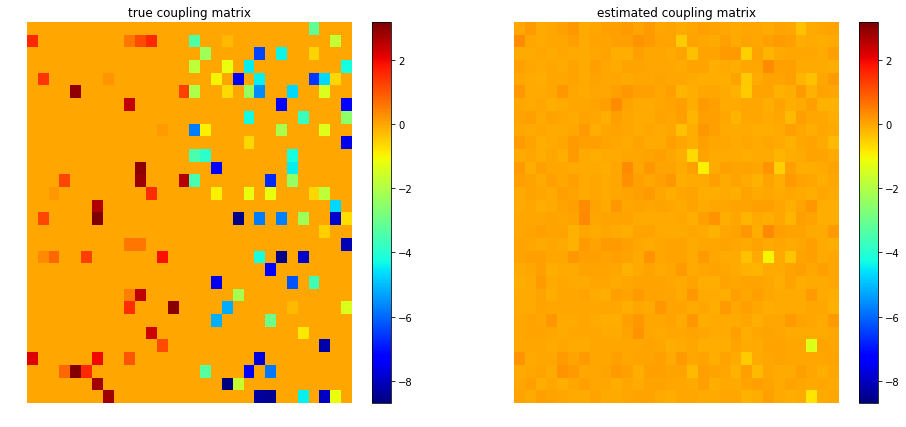

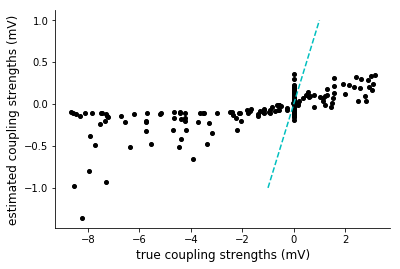

In [205]:
import matplotlib.pyplot as plt
# PLOT --------------------------------------------------------------------
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.imshow(D['J_true'], origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet, vmin=np.min(D['J_true']),vmax=np.max(D['J_true']))
plt.title('true coupling matrix')
plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.imshow(D['J_estim'], origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet, vmin=np.min(D['J_true']),vmax=np.max(D['J_true']))

plt.title('estimated coupling matrix')
plt.colorbar()
plt.axis('off')
savefig('plots/%s_Jestim.pdf' %filename)

plt.figure()
ax = plt.subplot()
idx = np.diag(np.ones(N))<1
plt.plot(np.ravel(D['J_true'][idx]), np.ravel(D['J_estim'][idx]), 'ok', 
         markersize=4)
plt.plot([-1, 1], [-1, 1], 'c--')
plt.xlabel('true coupling strengths (mV)', fontsize=12)
plt.ylabel('estimated coupling strengths (mV)', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
savefig('plots/%s_correlation.pdf' %filename)

# assess correlation for excitatory and inhibitory neurons separately
corr_e = np.corrcoef(np.ravel(D['J_estim'][D['J_true']>0]),np.ravel(D['J_true'][D['J_true']>0]))[0,1]
print('Correlation coefficient for excitatory neurons:',corr_e)
corr_i = np.corrcoef(np.ravel(D['J_estim'][D['J_true']<0]),np.ravel(D['J_true'][D['J_true']<0]))[0,1]
print('Correlation coefficient for inhibitory neurons:',corr_i)

np.save('Jestim_%s.npy' %filename, D['J_estim'])

(900, 10)


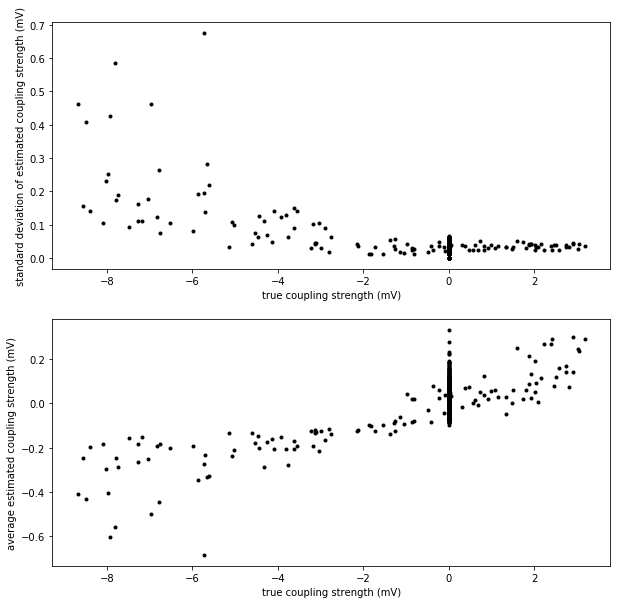

In [227]:
# load estimations from segments
num_segments = 10
Jestim_all = np.zeros((Nneurons_obs**2,num_segments))
for i in range(num_segments):
    name = 'data_N1000_T3000_leaky_current_Jestim_%s.npy' %i
    Jestim = np.load(name)
    Jestim_all[:,i] = Jestim.flatten()
print(Jestim_all.shape)
Jtrue = np.load('data_N1000_T3000_leaky_current_Jobs.npy')

figure(figsize=(10,10))
subplot(211)
sd = np.std(Jestim_all,1)
m = np.mean(Jestim_all,1)
plot(Jtrue.flatten(),sd,'ko',ms=3)
xlabel('true coupling strength (mV)')
ylabel('standard deviation of estimated coupling strength (mV)')
subplot(212)
plot(Jtrue.flatten(),m,'ko',ms=3)
xlabel('true coupling strength (mV)')
ylabel('average estimated coupling strength (mV)')
savefig('plots/estimation_variability.pdf',bbox_to_anchor='tight')
show()



### Modification of weights

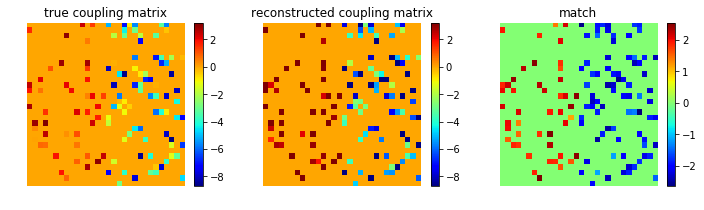

In [233]:
#### modify weights
synname = 'data_N1000_T3000_leaky_current_synapses.pkl'
synapses = pd.read_pickle(synname)
ex_w = synapses['ex_we'][0]
ex_w2 = ex_w.copy()
ex_j = synapses['ex_j'][0]
inh_w = synapses['inh_wi'][0]
inh_w2 = inh_w.copy()
inh_j = synapses['inh_j'][0]

# get original values for observed neurons
for i in range(Nneurons_obs):
    ind = obs_neurons_ind[i]
    
    pre_ind = np.where((synapses['ex_i'][0]==ind))[0]
    if len(pre_ind)!=0:
        # excitatory
        post_id = ex_j[pre_ind]
        weights_ind = []
        for ii,k in enumerate(obs_neurons_ind):
            b = np.where(post_id==k)[0]
            if len(b)!=0:
                weights_ind += list(pre_ind[b])
        
        ex_w2[weights_ind] += np.random.normal(2,0.3,len(weights_ind))
        
    else:
        # inibitory
        pre_ind = np.where((synapses['inh_i'][0]==ind-Nneurons_tot*0.8))[0]
        post_id = inh_j[pre_ind]
        weights_ind = []
        for ii,k in enumerate(obs_neurons_ind):
            b = np.where(post_id==k)[0]
            if len(b)!=0:
                weights_ind += list(pre_ind[b])
        inh_w2[weights_ind] += np.random.normal(-2,0.3,len(weights_ind))
synapses['ex_we'][0] = ex_w2
synapses['inh_wi'][0] = inh_w2

# check modified weights
Jreconstruct = np.zeros((Nneurons_tot,Nneurons_tot))
Jreconstruct[synapses['ex_i'][0],ex_j] = synapses['ex_we'][0]
Jreconstruct[synapses['inh_i'][0] + int(Nneurons_tot*0.8), inh_j] = synapses['inh_wi'][0]
Jreconstruct = Jreconstruct[obs_neurons_ind,:][:,obs_neurons_ind].T


# PLOT --------------------------------------------------------------------
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(Jtrue, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet, vmin=np.min(Jtrue),vmax=np.max(Jtrue))
plt.title('true coupling matrix')
plt.colorbar()
plt.axis('off')

plt.subplot(132)
plt.imshow(Jreconstruct, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet, vmin=np.min(Jtrue),vmax=np.max(Jtrue))
plt.title('reconstructed coupling matrix')
plt.colorbar()
plt.axis('off')

plt.subplot(133)
plt.imshow(Jreconstruct-Jtrue, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet)
plt.title('match')
plt.colorbar()
plt.axis('off')

plt.show()
# save new weights
synapses.to_pickle('data_N1000_T3000_leaky_current_synapses_2.pkl')

### Result of weight change estimation

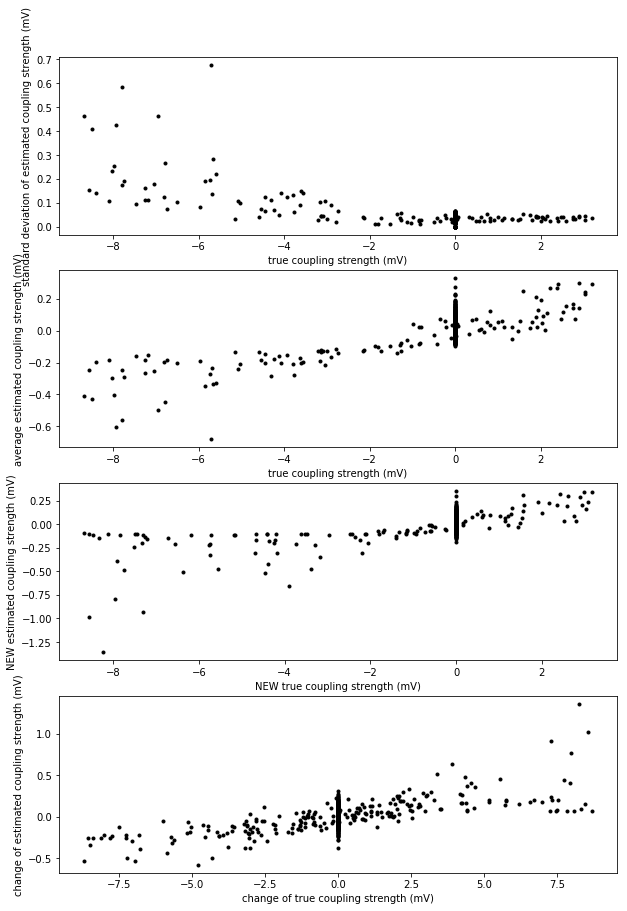

(-0.5, 29.5, 29.5, -0.5)

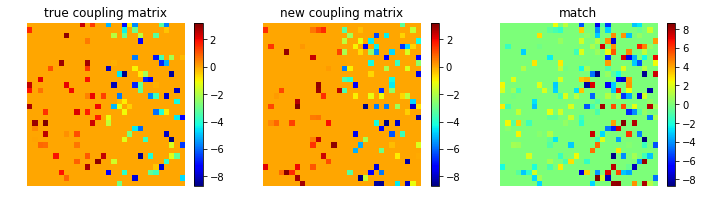

In [232]:
# load estimation after weights changed
Jestim_new = np.load('data_N1000_T300_leaky_current_2_Jestim_0.npy')
num_segments = 10

# load estimations from segments
Jestim_all = np.zeros((Nneurons_obs**2,num_segments))
for i in range(num_segments):
    Jestim = np.load('data_N1000_T3000_leaky_current_Jestim_%s.npy' %i)
    Jestim_all[:,i] = Jestim.flatten()
    
# load true connectivity matrices
factor = 2
Jtrue = np.load('data_N1000_T3000_leaky_current_Jobs.npy')
Jtrue_new = np.load('data_N1000_T300_leaky_current_2_Jobs.npy')

figure(figsize=(10,15))
subplot(411)
sd = np.std(Jestim_all,1)
m = np.mean(Jestim_all,1)
plot(Jtrue.flatten(),sd,'ko',ms=3)
xlabel('true coupling strength (mV)')
ylabel('standard deviation of estimated coupling strength (mV)')
subplot(412)
plot(Jtrue.flatten(),m,'ko',ms=3)
xlabel('true coupling strength (mV)')
ylabel('average estimated coupling strength (mV)')
subplot(413)
plot(Jtrue_new.flatten(),Jestim_new.flatten(),'ko',ms=3)
xlabel('NEW true coupling strength (mV)')
ylabel('NEW estimated coupling strength (mV)')
subplot(414)
plot(Jtrue.flatten()-Jtrue_new.flatten(),m-Jestim_new.flatten(),'ko',ms=3)
xlabel('change of true coupling strength (mV)')
ylabel('change of estimated coupling strength (mV)')
#savefig('plots/estimation_variability.pdf',bbox_to_anchor='tight')
show()


# PLOT MATRICES --------------------------------------------------------------------
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(Jtrue, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet, vmin=np.min(Jtrue),vmax=np.max(Jtrue))
plt.title('true coupling matrix')
plt.colorbar()
plt.axis('off')

plt.subplot(132)
plt.imshow(Jtrue_new, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet, vmin=np.min(Jtrue),vmax=np.max(Jtrue))
plt.title('new coupling matrix')
plt.colorbar()
plt.axis('off')

plt.subplot(133)
plt.imshow(Jtrue-Jtrue_new, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet)
plt.title('match')
plt.colorbar()
plt.axis('off')

(0, 50)

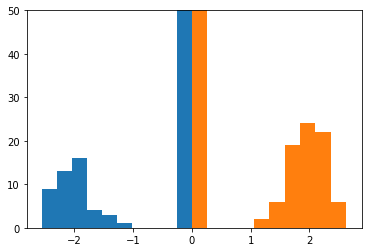

In [12]:
# check weight change once again

# load synapses
synapses1 = pd.read_pickle('data_N1000_T3000_leaky_current_synapses.pkl')
synapses2 = pd.read_pickle('data_N1000_T3000_leaky_current_synapses_2.pkl')

# plot
hist(synapses1['ex_we'][0]-synapses2['ex_we'][0],bins=10)
hist(synapses1['inh_wi'][0]-synapses2['inh_wi'][0],bins=10)
ylim((0,50))